In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
import re
from datetime import datetime

# Project Idea

Have you ever wondered why some actors keep getting cast in the same role? Why Dwayne Johnson always seems to plays the adventurous, headstrong and caring leader? Why Jason Staham is constantly cast as the gritty, hardboiled tough guy? <br>
This is called typecasting, the process by which an actor becomes strongly identified with particular roles, or characters having the same traits or coming from the same social or ethnic groups. We want to analyse the physical aspects of typecasting, by decoding the DNA of the characters on the silver screen throughout time and genres.<br>
<br>
We want to identify and observe the physical trends of actors playing the same role, and see them evolve over time, using image analysis and WikiData, in addition to the CMU Movie Summary Corpus. This analysis will eventually lead us to the question: <br>
***What role would you be typecasted in?***

### Project Plotline

#### 1) CMU Movie Summary Corpus Data Pre-processing
We are given a series of datasets in this corpus, with the metadata being the data of most interest for us. This metadata is comprised of two dataframes, the movie metadata and the characters metadata. As indicated in the CMU Movie Summary Corpus ReadMe, these two dataframes have a many variables. Let us first identify the variables of interest for our story. <br>
##### a) Identifying our variables of interests
+ Movie metadata: *Wiki_movieID, Movie Name, Release Date, Genres* <br>
+ Character metadata: *Wiki_movieID, Release Date, Character Name, Gender, Height, Ethinicity, Actor Name, Age at Movie Release* <br>
##### b) Cleaning and sorting our data
+ We then pre-process the dataframes:
    + We sort our movies dataframe by decades of release date.
    + We also sort our movies by genres before plotting the number of movies by genre to identify the most prevalent ones.
    + We first identify the percentage of missing data in each of our variables of interest as well as check for any errors *(such as a movie released in 1010 rather than 2010)*.
    + The genres and decades of release are added as variables to our movie metadata.
    + Our character metadata is merged with the movie metadata, correctly associating the characters and actors to their respective genres and decades of release.
#### 2) WikiData
A notable missing element of our character metadata is the classification of the characters as main, side or background characters. We also want as much data on the actors as possible, to help us identify recurring physical characteristics. <br>
As such, we add WikiData to our project and pre-process it, as we did with the CMU Movie Summary Corpus. 

#### 3) Image Analysis
Identification of physical elements would not be complete without analysis of the facial image of the actors. Do charismatic and headstrong protagonists share similarities in the shape of their jawline or in the colour of their eyes? <br>
We want to quantify the different elements of a face using machine learning before using said data to compare actors to each other, in the hope of observing ressemblances and trends between actors playing the similar character roles.

### 1.a) Loading Data and identifying variables of interest

In [2]:
#Loading our data
characters_df = pd.read_csv('data/character.metadata.tsv', delimiter="\t", 
                            names=['Wiki_movieID', 'Freebase_movieID', 'ReleaseDate', 'CharacterName', 'ActorDOB', 'ActorGender', 'ActorHeight', 'ActorEthnicity', 'ActorName', 'ActorAge', 'Freebase_charactermap', 'Freebase_characterID', 'Freebase_actorID'])
movies_df = pd.read_csv('data/movie.metadata.tsv', delimiter="\t", 
                        names=['Wiki_movieID', 'Freebase_movieID', 'MovieName', 'ReleaseDate', 'BoxOffice', 'Runtime', 'Languages', 'Countries', 'Genres'])

print("Size of 'Characters' DataFrame: %d" % len(characters_df))
print("Size of 'Movies' DataFrame: %d" % len(movies_df))

Size of 'Characters' DataFrame: 450669
Size of 'Movies' DataFrame: 81741


In [3]:
movies_df.head()

,Wiki_movieID,Freebase_movieID,MovieName,ReleaseDate,BoxOffice,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [4]:
characters_df.head()

,Wiki_movieID,Freebase_movieID,ReleaseDate,CharacterName,ActorDOB,ActorGender,ActorHeight,ActorEthnicity,ActorName,ActorAge,Freebase_charactermap,Freebase_characterID,Freebase_actorID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


As noted above, we identify the variables of interest for our project.
+ Movie metadata: *WikiID, Movie Name, Release Date, Genres* <br>
+ Character metadata: *WikiID, Release Date, Character Name, Gender, Height, Ethinicity, Actor Name, Age at Movie Release* <br>

### 1.b) Cleaning and Sorting our Data

In [5]:
#Functions
def percentage_missingdata(dataframe, column_name):
    notmissing = dataframe[column_name].count()
    totaldata = len(dataframe[column_name])
    percentage_missing = (1 - (notmissing/totaldata)) * 100
    
    return percentage_missing

def is_valid_date(date_string, format_string):
    try:
        datetime.strptime(date_string, format_string)
        return True
    except ValueError:
        return False

#### 1.b.i) Sorting Movie Dataframe by decades of release date

In [6]:
#We start by classifying our data per decades of release dates.
#Keeping only the year of release of the movies to classify them by decades
format1 = "%Y-%m-%d"
format2 = "%Y-%m"

for y in range(0,len(movies_df)):
    if isinstance(movies_df['ReleaseDate'][y], str):
        if is_valid_date(movies_df['ReleaseDate'][y],format1):
            date_obj = datetime.strptime(movies_df['ReleaseDate'][y], "%Y-%m-%d")
            movies_df.loc[y,'ReleaseDate'] = date_obj.year
            
    if isinstance(movies_df['ReleaseDate'][y], str):
        if is_valid_date(movies_df['ReleaseDate'][y],format2):
            date_obj = datetime.strptime(movies_df['ReleaseDate'][y], "%Y-%m")
            movies_df.loc[y,'ReleaseDate'] = date_obj.year
            
movies_df['ReleaseDate'] = movies_df['ReleaseDate'].astype(float)

In [7]:
#we notice an error in the movies dataset. The movie 'Hunting Season' is said to have a release date in 1010. This is impossible
#A quick google search reveals that the movie release year was 2010. Let us fix that.
huntingseason_error = movies_df.loc[movies_df['MovieName'] == 'Hunting Season'].index
movies_df.loc[huntingseason_error,'ReleaseDate'] = 2010.0

movies_df.sort_values(by='ReleaseDate', ascending=True, inplace=True)

In [8]:
#Classifying movies by decades. 
#We only have two movies before 1890s decade, released in 1888 and 1889. Let us include them in 1890s decade.
_1890s = movies_df.query('ReleaseDate < 1900.0')
_1900s = movies_df.query('ReleaseDate >= 1900.0 and ReleaseDate < 1910.0')
_1910s = movies_df.query('ReleaseDate >= 1910.0 and ReleaseDate < 1920.0')
_1920s = movies_df.query('ReleaseDate >= 1920.0 and ReleaseDate < 1930.0')
_1930s = movies_df.query('ReleaseDate >= 1930.0 and ReleaseDate < 1940.0')
_1940s = movies_df.query('ReleaseDate >= 1940.0 and ReleaseDate < 1950.0')
_1950s = movies_df.query('ReleaseDate >= 1950.0 and ReleaseDate < 1960.0')
_1960s = movies_df.query('ReleaseDate >= 1960.0 and ReleaseDate < 1970.0')
_1970s = movies_df.query('ReleaseDate >= 1970.0 and ReleaseDate < 1980.0')
_1980s = movies_df.query('ReleaseDate >= 1980.0 and ReleaseDate < 1990.0')
_1990s = movies_df.query('ReleaseDate >= 1980.0 and ReleaseDate < 2000.0')
_2000s = movies_df.query('ReleaseDate >= 2000.0 and ReleaseDate < 2010.0')
_2010s = movies_df.query('ReleaseDate >= 2010.0 and ReleaseDate < 2020.0')

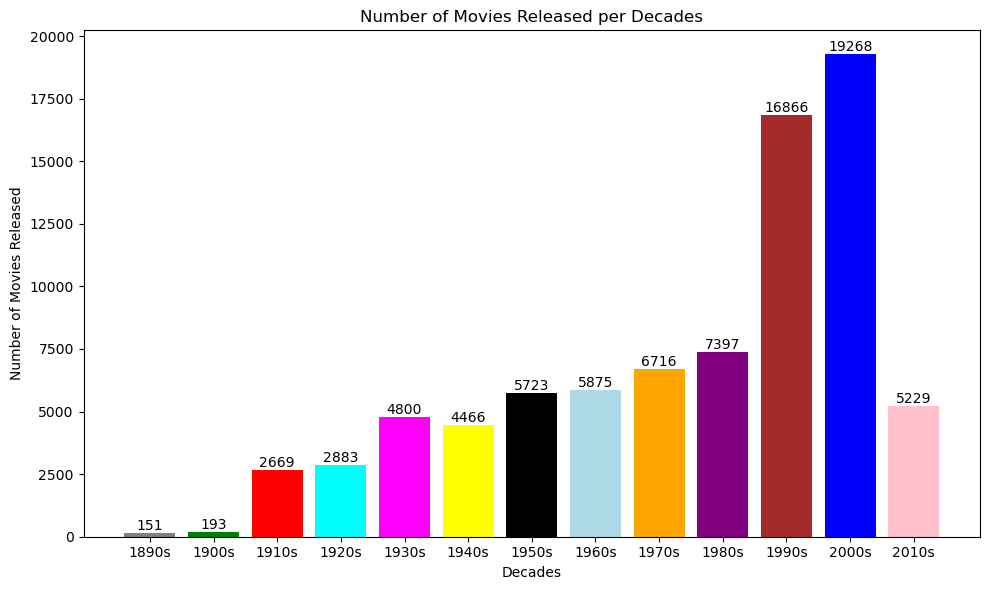

In [9]:
#We can plot the number of movies released per decades

movies_decades_data = {'Decades': ['1890s', '1900s', '1910s', '1920s', '1930s', '1940s', '1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s'],
                        'Number of Movies Released': [len(_1890s), len(_1900s), len(_1910s), len(_1920s), len(_1930s), len(_1940s), len(_1950s),
                                                     len(_1960s), len(_1970s), len(_1980s), len(_1990s), len(_2000s), len(_2010s)]}
perdecades_df = pd.DataFrame(movies_decades_data)

plt.figure(figsize=(10,6))
moviedecades_barchart = plt.bar(perdecades_df['Decades'], perdecades_df['Number of Movies Released'], 
        color = ['gray', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'lightblue', 
                 'orange', 'purple', 'brown', 'blue', 'pink'])

for bar in moviedecades_barchart:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 1), ha='center', va='bottom')

plt.xlabel('Decades')
plt.ylabel('Number of Movies Released')
plt.title('Number of Movies Released per Decades')
plt.tight_layout()
plt.show()

#### 1.b.ii) Sorting Movie Dataframe by genres

In [10]:
#We now want to classify our movie data by genre.
copy_genres = movies_df.copy()

copy_genres['Genres'] = copy_genres['Genres'].str.replace('[{}]', '', regex=True)
copy_genres['Genres'] = copy_genres['Genres'].apply(lambda x: x.split(', ') if pd.notna(x) else x)

flat_characteristics = [char for sublist in copy_genres['Genres'] for char in sublist]

characteristics_counts = Counter(flat_characteristics)

counts_df = pd.DataFrame.from_dict(characteristics_counts, orient='index', columns=['Count'])

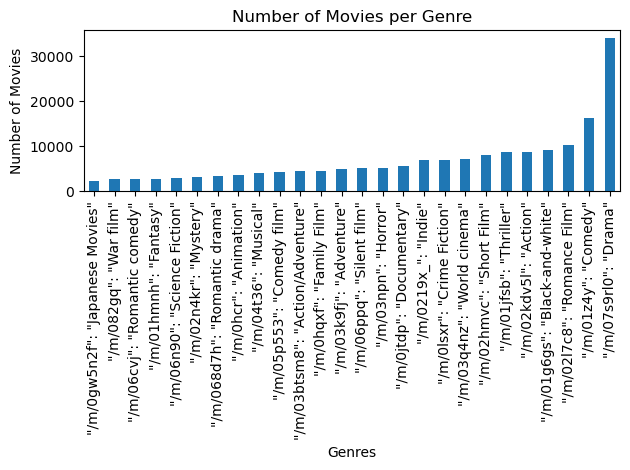

In [11]:
#Plotting movies by genres

#We notice that there's 2294 counts of films with missing genres, characterised by an empty string. 
#As such we determine our threshold to be over 2300 for the genre occurences.
counts_df = counts_df[counts_df['Count'] >= 2300]

counts_df.sort_values(by='Count', ascending=True, inplace=True)

counts_df.plot(kind='bar', legend=False)
plt.xlabel('Genres')
plt.ylabel('Number of Movies')
plt.title('Number of Movies per Genre')
plt.tight_layout()
plt.show()

#### 1.b.iii) Checking the percentage of missing data for each variable of interest

In [12]:
#change the {} into NaNs
movies_df.replace({'{}': pd.NA}, inplace=True)
characters_df.replace({'{}': pd.NA}, inplace=True)

In [13]:
#Missing data in movies_df
movie_variables = ['Wiki_movieID', 'MovieName', 'ReleaseDate','Genres']
percentage_missing_movies = []

for v in range(0, len(movie_variables)):
    percentage_missing_movies.append(percentage_missingdata(movies_df, movie_variables[v]))

missing_data_movies_df = pd.DataFrame({'Variables of Interest': movie_variables,
                                           'Percentage of Missing Data': percentage_missing_movies})  

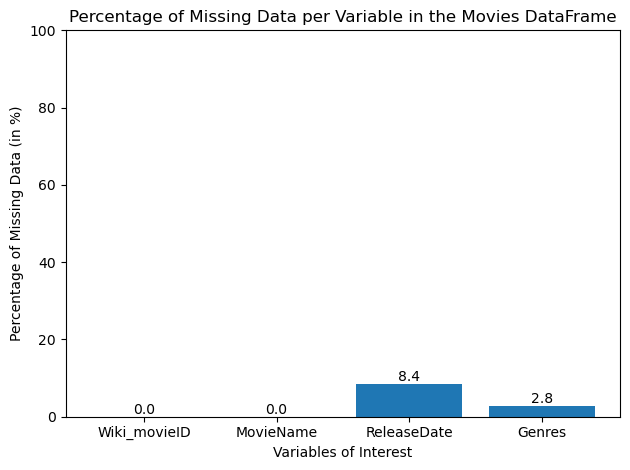

In [14]:
#Plotting the percentage of missing data for the variables of movies_df
bars = plt.bar(missing_data_movies_df['Variables of Interest'], missing_data_movies_df['Percentage of Missing Data'])
plt.ylim(0, 100)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 1), ha='center', va='bottom')

plt.xlabel('Variables of Interest')
plt.ylabel('Percentage of Missing Data (in %)')
plt.title('Percentage of Missing Data per Variable in the Movies DataFrame')
plt.tight_layout()
plt.show()

We notice that we have very low percentages of missing data for our variables of interest. <br>
We have 0% of missing data for both our Wiki_movieID and Movie Name, as such we can associate each movie to its respective Wikipedia Page using WikiData without any errors.<br>
We have 8.4% of missing data for Release Date variable and 2.8% of missing data for Genres variable. These values are both very low and under 10%. Generally, when we have more than 10% of missing data, our data is likely to be biased. As such this is not the case for our Movies dataframe.<br>

In [15]:
#Missing data in characters_df
character_variables = ['Wiki_movieID', 'ReleaseDate', 'CharacterName','ActorGender', 'ActorHeight', 
                                                    'ActorEthnicity', 'ActorName', 'ActorAge']
percentage_missing_characters = []

for var in range(0, len(character_variables)):
    percentage_missing_characters.append(percentage_missingdata(characters_df, character_variables[var]))

missing_data_characters_df = pd.DataFrame({'Variables of Interest': character_variables,
                                           'Percentage of Missing Data': percentage_missing_characters})                                                                                                                             

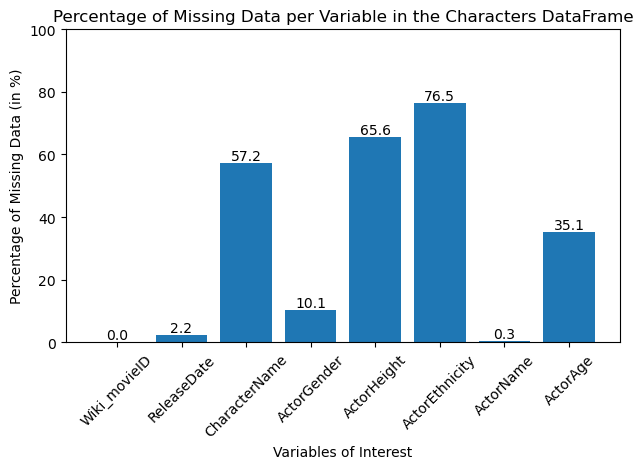

In [16]:
#Plotting the percentage of missing data for the variables of characters_df
bars = plt.bar(missing_data_characters_df['Variables of Interest'], missing_data_characters_df['Percentage of Missing Data'])
plt.ylim(0, 100)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 1), ha='center', va='bottom')

plt.xticks(rotation=45)
plt.xlabel('Variables of Interest')
plt.ylabel('Percentage of Missing Data (in %)')
plt.title('Percentage of Missing Data per Variable in the Characters DataFrame')
plt.tight_layout()
plt.show()

#### DRAFT Project plotline
1) Finish movies_df exploratory data analysis by sorting the dataset by genres
2) Associate the characters to their respective movies and as such associate them to their movie's genres --> sorting the characters by genre
3) Sort the characters by decade and genre
4) Figure out the main characters from the side characters using freebase character map & plot summary --> Hardest part!

#### 1.b.iv) Adding Decades & Separate Genres Variables to the Movie DataFrame

#### 1.b.v) Merging Movie and Character DataFrames

In [17]:
characters_df.head()

,Wiki_movieID,Freebase_movieID,ReleaseDate,CharacterName,ActorDOB,ActorGender,ActorHeight,ActorEthnicity,ActorName,ActorAge,Freebase_charactermap,Freebase_characterID,Freebase_actorID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [18]:
ethnicities = characters_df.ActorEthnicity.values

In [19]:
characters_df_with_movieinfo = characters_df.merge(movies_df, on=['Wiki_movieID'], how = 'left', suffixes=("", "_y")).drop(['Freebase_movieID_y', 'ReleaseDate_y'], axis=1)
characters_df_with_movieinfo.head()

,Wiki_movieID,Freebase_movieID,ReleaseDate,CharacterName,ActorDOB,ActorGender,ActorHeight,ActorEthnicity,ActorName,ActorAge,Freebase_charactermap,Freebase_characterID,Freebase_actorID,MovieName,BoxOffice,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."


### 2) Adding Actor WikiData

### 3) Image Analysis